In [36]:
import os

cwd = os.getcwd()

if cwd.endswith('prototype'):
    PATH = os.path.join('..', 'data', 'hanacaraka-roboflow')
    os.chdir(PATH)
    new_cwd = os.getcwd()

    print(f"The current working directory was: {cwd}")
    print(f"It has been changed to: {new_cwd}")

else:
    print(f"The current working directory is: {cwd}")

The current working directory is: d:\Python\hanacaraka-classifier\data\hanacaraka-roboflow


Load Training Data

In [37]:
import pandas as pd

train_df = pd.read_csv('train_classes.csv')
train_df.head()

,filename,ba,ca,da,dha,ga,ha,ja,ka,la,...,na,nga,nya,pa,ra,sa,ta,tha,wa,ya
0,na_original_na4-nando-png_047b8e4a-23d2-4984-9...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,ja131-pred3_png.rf.641be3c0db040a9ef0d9ca3e764...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ka_original_ka24-mine3-rm5-png_323626c9-08f4-4...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,wa169-pred-r10_png.rf.65c4b25eba5d8f672b9639ac...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,sa148-mine-rm5_png.rf.65b2c2b62e59d2eb71afea1b...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [38]:
classes = train_df.columns[1:]

print(f"Classes: {classes}")

Classes: Index([' ba', ' ca', ' da', ' dha', ' ga', ' ha', ' ja', ' ka', ' la', ' ma',
       ' na', ' nga', ' nya', ' pa', ' ra', ' sa', ' ta', ' tha', ' wa',
       ' ya'],
      dtype='object')


In [39]:
train_df['label'] = train_df[classes].idxmax(axis=1)
train_df.drop(columns=classes, inplace=True)

train_df.head()

,filename,label
0,na_original_na4-nando-png_047b8e4a-23d2-4984-9...,na
1,ja131-pred3_png.rf.641be3c0db040a9ef0d9ca3e764...,ja
2,ka_original_ka24-mine3-rm5-png_323626c9-08f4-4...,ka
3,wa169-pred-r10_png.rf.65c4b25eba5d8f672b9639ac...,wa
4,sa148-mine-rm5_png.rf.65b2c2b62e59d2eb71afea1b...,sa


Load Validation Data

In [40]:
val_df = pd.read_csv('valid_classes.csv')
classes = val_df.columns[1:]
val_df['label'] = val_df[classes].idxmax(axis=1)
val_df.drop(columns=classes, inplace=True)

val_df.head()

,filename,label
0,ba_original_ba58-mine-r5-png_da355617-4601-42c...,ba
1,tha_original_tha59-mine-png_14942c0b-cf89-4c60...,tha
2,ca63-mine-b_png.rf.6651f23d5e3923e3f5869f5150a...,ca
3,wa_original_wa8-meki-b-png_71916382-2490-4423-...,wa
4,la_original_la9-meki-png_2fda8a06-5a2e-4631-b9...,la


Load Testing Data

In [41]:
test_df = pd.read_csv('test_classes.csv')
classes = test_df.columns[1:]
test_df['label'] = test_df[classes].idxmax(axis=1)
test_df.drop(columns=classes, inplace=True)

test_df.head()

,filename,label
0,ya_original_ya92-mine3-b-png_bbe9944d-6ddd-4bf...,ya
1,da86-mine_png.rf.11496a515f7f6cc4bec9df9340c77...,da
2,dha_original_dha90-mine3-b-png_10e4954e-1ddc-4...,dha
3,ka_original_ka83-mine3-b-png_a996444a-a42f-4b0...,ka
4,tha_original_tha97-mine3-png_446e0772-7dda-432...,tha


# Build the Data Generators (Data Augmentation)

In [42]:
label_encoded = {}

for i, label in enumerate(train_df['label'].unique()):
    label_encoded[label] = i
    
label_encoded

{' na': 0,
 ' ja': 1,
 ' ka': 2,
 ' wa': 3,
 ' sa': 4,
 ' nya': 5,
 ' dha': 6,
 ' pa': 7,
 ' nga': 8,
 ' tha': 9,
 ' ra': 10,
 ' ya': 11,
 ' da': 12,
 ' ca': 13,
 ' ha': 14,
 ' ga': 15,
 ' ta': 16,
 ' ma': 17,
 ' ba': 18,
 ' la': 19}

In [43]:
X_train = train_df['filename']
y_train = train_df['label']

X_val = val_df['filename']
y_val = val_df['label']

X_test = test_df['filename']
y_test = test_df['label']

print(f"{X_train.shape[0]} {X_val.shape[0]} {X_test.shape[0]}")

2700 800 400


In [44]:
from torch.utils.data import Dataset
from PIL import Image

class HanacarakaDataset (Dataset):
    def __init__(self, x, y, maps_label=label_encoded, transform=None):
        self.X = x
        self.y = y
        self.dicts = maps_label
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = Image.open('images/' + self.X.iloc[idx]).convert('RGB')
        label = self.dicts[self.y.iloc[idx]]
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

In [45]:
import torchvision.transforms as transforms
import numpy as np
import cv2

from torch.utils.data import DataLoader

def cvt_grayscale(img):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
    return Image.fromarray(img)

def cvt_rgb(img):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

def erode_img(img, kernel_size=(3,3)):
    kernel = np.ones(kernel_size, np.uint8)
    img = cv2.erode(np.array(img), kernel, iterations=1)
    return Image.fromarray(img)

def adaptive_threshold(img):
    img = cv2.adaptiveThreshold(np.array(img), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return Image.fromarray(img)

train_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.Lambda(cvt_grayscale),
    # transforms.Lambda(erode_img),
    transforms.Lambda(adaptive_threshold),
    transforms.RandomRotation(10, fill=255),
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    # transforms.RandomAdjustSharpness(2),
    # transforms.RandomResizedCrop(100, scale=(0.8, 1.0), fill=255, ratio=(0.75, 1.3333333333333333)),
    transforms.Lambda(cvt_rgb),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.Lambda(cvt_grayscale),
    # transforms.Lambda(erode_img),
    transforms.Lambda(adaptive_threshold),
    transforms.Lambda(cvt_rgb),
    transforms.ToTensor(),
])

train_dataset = HanacarakaDataset(X_train, y_train, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = HanacarakaDataset(X_val, y_val, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = HanacarakaDataset(X_test, y_test, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [46]:
feature, label = next(iter(train_loader))
feature.shape, len(train_loader)

(torch.Size([32, 3, 100, 100]), 85)

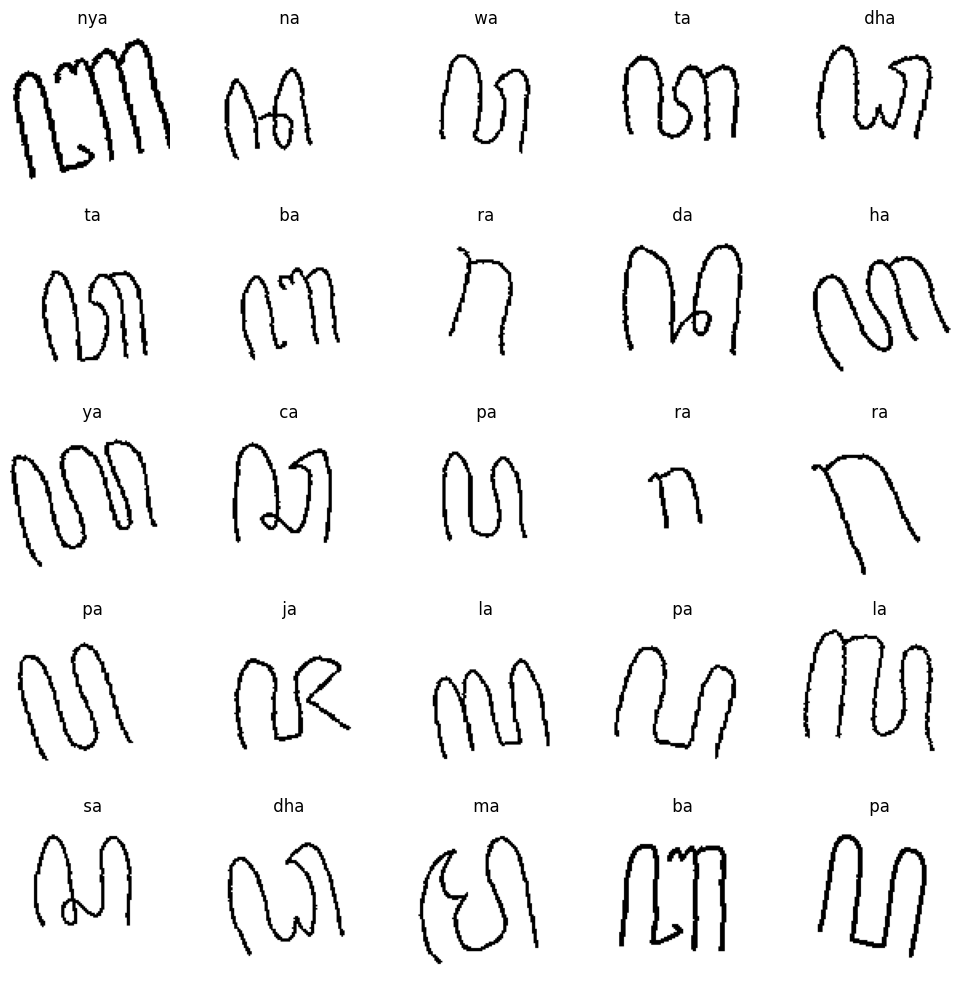

In [47]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for img, label, ax in zip(feature, label, axs.flatten()):
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    label = list(label_encoded.keys())[list(label_encoded.values()).index(label)]
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [128]:
# def findConv2dOutShape(hin,win,conv,pool=2):
#     # get conv arguments
#     kernel_size=conv.kernel_size
#     stride=conv.stride
#     padding=conv.padding
#     dilation=conv.dilation

#     hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
#     wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

#     if pool:
#         hout/=pool
#         wout/=pool
#     return int(hout),int(wout)

# import torch.nn as nn
# import torch
# import torch.nn.functional as F

# # Neural Network
# class Network(nn.Module):
    
#     # Network Initialisation
#     def __init__(self, params):
        
#         super(Network, self).__init__()
    
#         Cin,Hin,Win=params["shape_in"]
#         init_f=params["initial_filters"] 
#         num_fc1=params["num_fc1"]  
#         num_classes=params["num_classes"] 
#         self.dropout_rate=params["dropout_rate"] 
        
#         # Convolution Layers
#         self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
#         h,w=findConv2dOutShape(Hin,Win,self.conv1)
#         self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
#         h,w=findConv2dOutShape(h,w,self.conv2)
#         self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
#         h,w=findConv2dOutShape(h,w,self.conv3)
#         self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
#         h,w=findConv2dOutShape(h,w,self.conv4)
        
#         # compute the flatten size
#         self.num_flatten=h*w*8*init_f
#         self.fc1 = nn.Linear(self.num_flatten, num_fc1)
#         self.fc2 = nn.Linear(num_fc1, num_classes)

#     def forward(self,X):
        
#         # Convolution & Pool Layers
#         X = F.relu(self.conv1(X)); 
#         X = F.max_pool2d(X, 2, 2)
#         X = F.relu(self.conv2(X))
#         X = F.max_pool2d(X, 2, 2)
#         X = F.relu(self.conv3(X))
#         X = F.max_pool2d(X, 2, 2)
#         X = F.relu(self.conv4(X))
#         X = F.max_pool2d(X, 2, 2)

#         X = X.view(-1, self.num_flatten)
        
#         X = F.relu(self.fc1(X))
#         X=F.dropout(X, self.dropout_rate)
#         X = self.fc2(X)
#         return F.log_softmax(X, dim=1)

In [157]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d( kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(576, 32)
        self.fc2 = nn.Linear(32, 20)
        self.flatten = nn.Flatten()
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.flatten(x)
       
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



In [158]:
def train(
        model, train_loader, val_loader, criterion, optimizer, early_stop_epochs=5, max_epochs=20
):
    min_val_loss = float('inf')
    early_stop_counter = 0
    epoch = 0

    while epoch < max_epochs:
        model.train()
        train_loss = 0.0
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for feature, label in train_loader:
            feature, label = feature.to(device), label.to(device)

            optimizer.zero_grad()
            output = model(feature)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for feature, label in val_loader:
                feature, label = feature.to(device), label.to(device)

                output = model(feature)
                loss = criterion(output, label)

                val_loss += loss.item()

                _, predicted = torch.max(output.data, 1)
                total_preds += label.size(0)
                correct_preds += (predicted == label).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_preds / total_preds
        print(
            f'Epoch {epoch+1} | '
            f'Train Loss: {train_loss/len(train_loader):.4f} | '
            f'Val Loss: {avg_val_loss:.4f} | '
            f'Val Accuracy: {val_accuracy:.4f} | '
        )

        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_epochs:
            print('Early Stopping...')
            break

        epoch += 1

    return model

In [159]:
# params_model={
#         "shape_in": (3,100,100), 
#         "initial_filters": 8,    
#         "num_fc1": 100,
#         "dropout_rate": 0.25,
#         "num_classes": 20}

import torch 


# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)

criterion = nn.NLLLoss()

Learning Rate 1e-3

In [160]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

model = train(model, train_loader, val_loader, criterion, optimizer)

Epoch 1 | Train Loss: 3.0023 | Val Loss: 2.9995 | Val Accuracy: 0.0500 | 
Epoch 2 | Train Loss: 2.9921 | Val Loss: 2.9373 | Val Accuracy: 0.1375 | 
Epoch 3 | Train Loss: 2.4911 | Val Loss: 2.2015 | Val Accuracy: 0.3375 | 
Epoch 4 | Train Loss: 1.8574 | Val Loss: 1.7556 | Val Accuracy: 0.5513 | 
Epoch 5 | Train Loss: 1.5203 | Val Loss: 1.4193 | Val Accuracy: 0.6312 | 
Epoch 6 | Train Loss: 1.3962 | Val Loss: 1.3008 | Val Accuracy: 0.6488 | 
Epoch 7 | Train Loss: 1.2656 | Val Loss: 1.1887 | Val Accuracy: 0.6750 | 
Epoch 8 | Train Loss: 1.1909 | Val Loss: 1.2431 | Val Accuracy: 0.7113 | 
Epoch 9 | Train Loss: 1.1677 | Val Loss: 1.0154 | Val Accuracy: 0.7575 | 
Epoch 10 | Train Loss: 1.1254 | Val Loss: 1.0999 | Val Accuracy: 0.7137 | 
Epoch 11 | Train Loss: 1.0573 | Val Loss: 1.1214 | Val Accuracy: 0.7225 | 
Epoch 12 | Train Loss: 1.0080 | Val Loss: 0.9642 | Val Accuracy: 0.7638 | 
Epoch 13 | Train Loss: 0.9473 | Val Loss: 1.0526 | Val Accuracy: 0.7538 | 
Epoch 14 | Train Loss: 0.9942 | Va

Learning Rate 1e-4

In [161]:


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model = train(model, train_loader, val_loader, criterion, optimizer)

Epoch 1 | Train Loss: 0.7313 | Val Loss: 0.7216 | Val Accuracy: 0.8313 | 
Epoch 2 | Train Loss: 0.7199 | Val Loss: 0.7359 | Val Accuracy: 0.8187 | 
Epoch 3 | Train Loss: 0.7287 | Val Loss: 0.7778 | Val Accuracy: 0.8200 | 
Epoch 4 | Train Loss: 0.6908 | Val Loss: 0.7339 | Val Accuracy: 0.8200 | 
Epoch 5 | Train Loss: 0.7209 | Val Loss: 0.7706 | Val Accuracy: 0.8163 | 
Epoch 6 | Train Loss: 0.7103 | Val Loss: 0.7522 | Val Accuracy: 0.8313 | 
Early Stopping...


Testing Model on Test Data

In [162]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for feature, label in test_loader:
            feature, label = feature.to(device), label.to(device)

            output = model(feature)
            _, predicted = torch.max(output, 1)

            total += label.size(0)
            correct += (predicted == label).sum().item()

    return correct/total

In [163]:
test(model, test_loader)

0.83

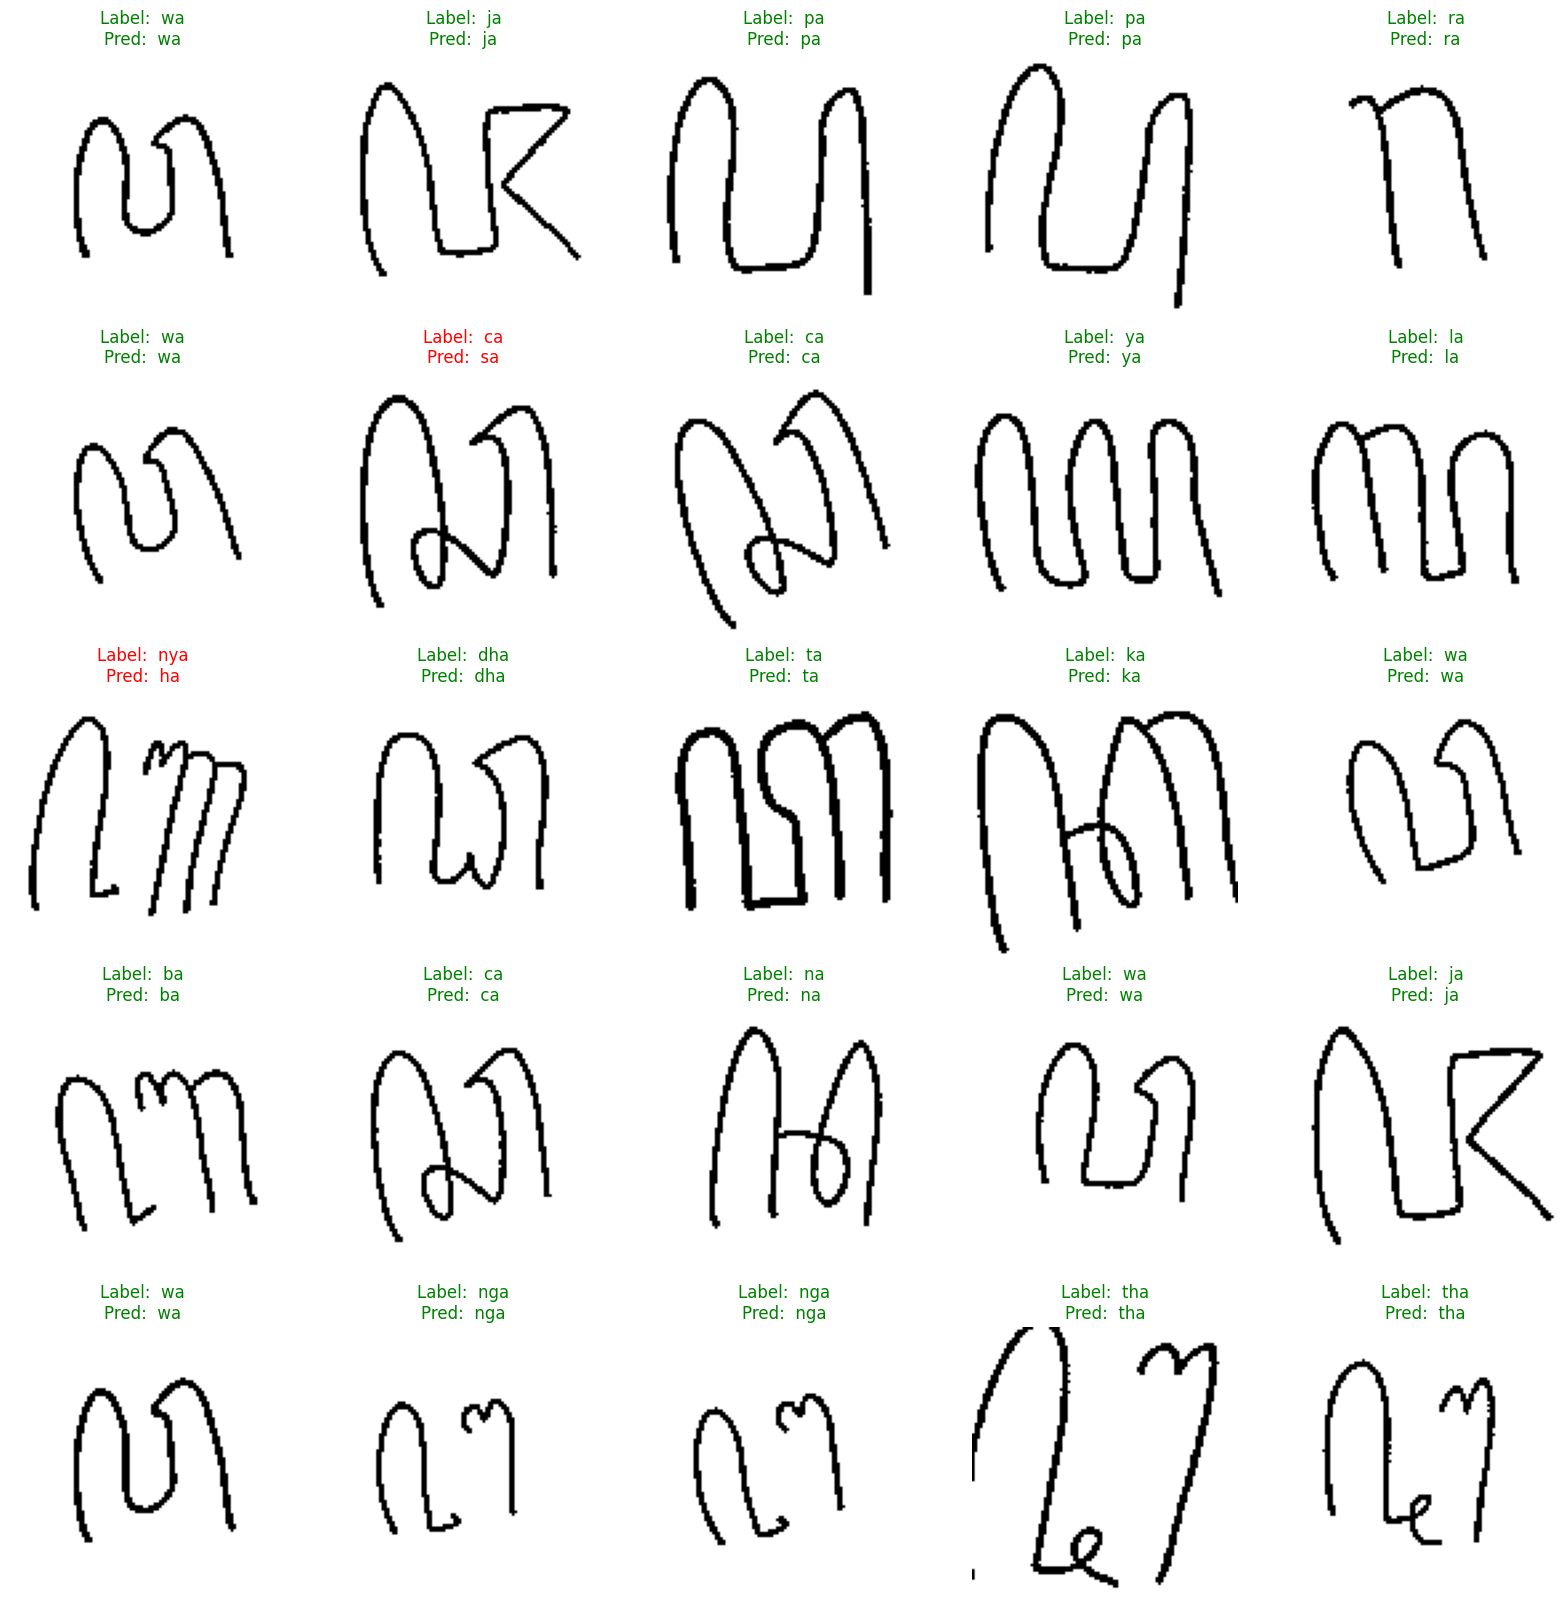

In [164]:
for feature, label in test_loader:
    feature, label = feature.to(device), label.to(device)
    output = model(feature)
    _, predicted = torch.max(output, 1)

    break

fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for img, label, pred, ax in zip(feature, label, predicted, axs.flatten()):
    ax.imshow(img.permute(1, 2, 0).squeeze().to('cpu'), cmap='gray')
    ax.axis('off')
    label = list(label_encoded.keys())[list(label_encoded.values()).index(label)]
    pred = list(label_encoded.keys())[list(label_encoded.values()).index(pred)]
    if label == pred:
        color = 'green'
    else:
        color = 'red'
    ax.set_title(f'Label: {label}\nPred: {pred}', color=color)